In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17483, done.
remote: Total 17483 (delta 0), reused 0 (delta 0), pack-reused 17483 (from 1)
Receiving objects: 100% (17483/17483), 16.58 MiB | 22.49 MiB/s, done.
Resolving deltas: 100% (11991/11991), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━

In [ ]:
!pip install torchvision matplotlib

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tqdm
import zipfile
from tqdm import tqdm
import os

zip_path = '/content/drive/MyDrive/frames.zip'
extract_path = '/content/frames2'

# Mở file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()                 # Lấy danh sách file trong zip
    print(f"Tổng số file cần giải nén: {len(file_list)}")

    # Tạo thư mục đích nếu chưa có
    os.makedirs(extract_path, exist_ok=True)

    # Giải nén từng file với tqdm hiển thị tiến trình
    for file in tqdm(file_list, desc="Đang giải nén", unit="file"):
        zip_ref.extract(member=file, path=extract_path)

print("Giải nén hoàn tất!")


Tổng số file cần giải nén: 44220


Đang giải nén: 100%|██████████| 44220/44220 [01:56<00:00, 379.71file/s]

Giải nén hoàn tất!


In [ ]:
# Kiểm tra nội dung giải nén
import os
os.listdir(extract_path)


['frames']

In [ ]:
data_dir = '/content/frames2'

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # resize ảnh cho CNN xử lý dễ hơn
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
# Kiểm tra device
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: False
Device: CPU


# Dataset và model

In [16]:

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Dataset
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        if not os.path.exists(root_dir):
            raise ValueError(f"Thư mục {root_dir} không tồn tại!")

        for label_type, label in [('real', 0), ('fake', 1)]:
            class_dir = os.path.join(root_dir, label_type)
            if not os.path.exists(class_dir):
                continue
            for subdir, _, files in os.walk(class_dir):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(subdir, file))
                        self.labels.append(label)

        if len(self.image_paths) == 0:
            raise ValueError("Không tìm thấy ảnh nào trong thư mục real/ hoặc fake/!")

        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx >= len(self.image_paths):
            raise IndexError(f"Index {idx} ngoài phạm vi dataset")
        try:
            img_path = self.image_paths[idx]
            label = self.labels[idx]
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            return None, None


# Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)

        # In số layer học
        learnable_layers = sum(1 for _ in self.modules() if isinstance(_, (nn.Conv2d, nn.Linear)))
        print(f"Number of learnable layers: {learnable_layers}")

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Kiểm tra model
model = CNNModel()
print("Model defined successfully")

Number of learnable layers: 5
Model defined successfully


# Chia train/test dataset

In [17]:
from torch.utils.data import DataLoader, random_split

# Load dataset
data_dir = "/content/frames2/frames"
dataset = DeepfakeDataset(data_dir)
print(f"Total images: {len(dataset)}")

# Chia train/test (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print("Data loaders created successfully")

Total images: 42217
Train size: 33773, Test size: 8444
Data loaders created successfully


# Huấn luyện model

In [19]:
import torch.optim as optim
from tqdm import tqdm
import sys

# Khởi tạo model
device = torch.device("cpu")
model = CNNModel().to(device)
print("Model initialized")

# Loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Huấn luyện

# Train Epoch 1
print("\nEpoch 1/5")
model.train()
train_loss = 0.0
num_batches = 0
with tqdm(train_loader, desc="Training", unit="batch") as t:
    for i, (images, labels) in enumerate(t):
        if images is None or labels is None:
            print("Skipping invalid batch")
            continue
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
        # Cập nhật loss trung bình mỗi 100 batch
        if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
            avg_loss = train_loss / num_batches
            t.set_postfix({"Train Loss": f"{avg_loss:.4f}"})


# Train Epoch 2
print("\nEpoch 2/5")
model.train()
train_loss = 0.0
num_batches = 0
with tqdm(train_loader, desc="Training", unit="batch") as t:
    for i, (images, labels) in enumerate(t):
        if images is None or labels is None:
            print("Skipping invalid batch")
            continue
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
        if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
            avg_loss = train_loss / num_batches
            t.set_postfix({"Train Loss": f"{avg_loss:.4f}"})


# Train Epoch 3
print("\nEpoch 3/5")
model.train()
train_loss = 0.0
num_batches = 0
with tqdm(train_loader, desc="Training", unit="batch") as t:
    for i, (images, labels) in enumerate(t):
        if images is None or labels is None:
            print("Skipping invalid batch")
            continue
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
        if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
            avg_loss = train_loss / num_batches
            t.set_postfix({"Train Loss": f"{avg_loss:.4f}"})


# Train Epoch 4
print("\nEpoch 4/5")
model.train()
train_loss = 0.0
num_batches = 0
with tqdm(train_loader, desc="Training", unit="batch") as t:
    for i, (images, labels) in enumerate(t):
        if images is None or labels is None:
            print("Skipping invalid batch")
            continue
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
        if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
            avg_loss = train_loss / num_batches
            t.set_postfix({"Train Loss": f"{avg_loss:.4f}"})


# Train Epoch 5
print("\nEpoch 5/5")
model.train()
train_loss = 0.0
num_batches = 0
with tqdm(train_loader, desc="Training", unit="batch") as t:
    for i, (images, labels) in enumerate(t):
        if images is None or labels is None:
            print("Skipping invalid batch")
            continue
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
        if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
            avg_loss = train_loss / num_batches
            t.set_postfix({"Train Loss": f"{avg_loss:.4f}"})


    # Đánh giá
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if images is None or labels is None:
                continue
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total if total > 0 else 0
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_acc:.2f}%")

    # Lưu model tốt nhất
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with accuracy {best_acc:.2f}% to {best_model_path}")

    model.train()

print("Training completed")

Number of learnable layers: 5
Model initialized

Epoch 1/5


Training: 100%|██████████| 4222/4222 [10:45<00:00,  6.54batch/s, Train Loss=0.6949]



Epoch 2/5


Training: 100%|██████████| 4222/4222 [10:10<00:00,  6.91batch/s, Train Loss=0.6893]



Epoch 3/5


Training: 100%|██████████| 4222/4222 [10:02<00:00,  7.01batch/s, Train Loss=0.6893]



Epoch 4/5


Training: 100%|██████████| 4222/4222 [10:07<00:00,  6.95batch/s, Train Loss=0.6893]



Epoch 5/5


Training: 100%|██████████| 4222/4222 [10:12<00:00,  6.89batch/s, Train Loss=0.6893]


Test Loss: 0.6885, Test Accuracy: 54.86%
Saved best model with accuracy 54.86% to /content/drive/MyDrive/Deepfake_Model/cnn_deepfake_detector.pt
Training completed


# Dự đoán trên tập test

In [20]:
def predict(model, loader, device):
    model.eval()
    predictions = []
    probabilities = []
    with torch.no_grad():
        for images, _ in loader:
            if images is None:
                continue
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    return predictions, probabilities

# Dự đoán
device = torch.device("cpu")
print("\nSample predictions on test set:")
preds, probs = predict(model, test_loader, device)
for i, (pred, prob) in enumerate(zip(preds[:5], probs[:5])):
    label = "real" if pred == 0 else "fake"
    print(f"Sample {i+1}: Predicted {label} (Prob: real={prob[0]:.4f}, fake={prob[1]:.4f})")


Sample predictions on test set:
Sample 1: Predicted fake (Prob: real=0.4577, fake=0.5423)
Sample 2: Predicted fake (Prob: real=0.4577, fake=0.5423)
Sample 3: Predicted fake (Prob: real=0.4577, fake=0.5423)
Sample 4: Predicted fake (Prob: real=0.4577, fake=0.5423)
Sample 5: Predicted fake (Prob: real=0.4577, fake=0.5423)


In [21]:
# Load model
model = CNNModel()
model.load_state_dict(torch.load("/content/drive/MyDrive/Deepfake_Model/cnn_deepfake_detector.pt"))
model.eval()
model.to(torch.device("cpu"))
print("Model loaded successfully from Google Drive")

Number of learnable layers: 5
Model loaded successfully from Google Drive


# kiểm tra lớp layer kém nhất

In [22]:
#Kiểm tra vanishing gradient
def check_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            print(f"{name} - Grad Norm: {grad_norm:.6f}")
        else:
            print(f"{name} - No gradient (frozen or not used)")

# Sau mỗi backward(), có thể gọi:
check_gradients(model)

conv1.weight - No gradient (frozen or not used)
conv1.bias - No gradient (frozen or not used)
bn1.weight - No gradient (frozen or not used)
bn1.bias - No gradient (frozen or not used)
conv2.weight - No gradient (frozen or not used)
conv2.bias - No gradient (frozen or not used)
bn2.weight - No gradient (frozen or not used)
bn2.bias - No gradient (frozen or not used)
conv3.weight - No gradient (frozen or not used)
conv3.bias - No gradient (frozen or not used)
bn3.weight - No gradient (frozen or not used)
bn3.bias - No gradient (frozen or not used)
fc1.weight - No gradient (frozen or not used)
fc1.bias - No gradient (frozen or not used)
fc2.weight - No gradient (frozen or not used)
fc2.bias - No gradient (frozen or not used)


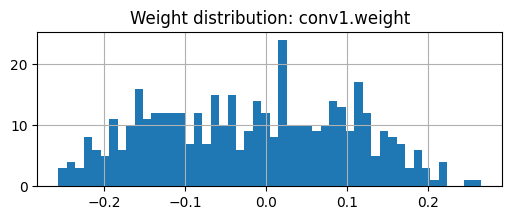

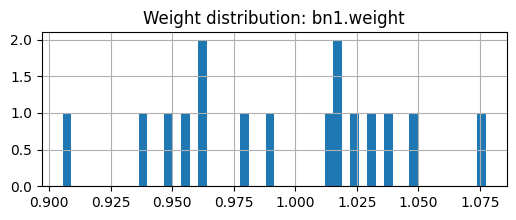

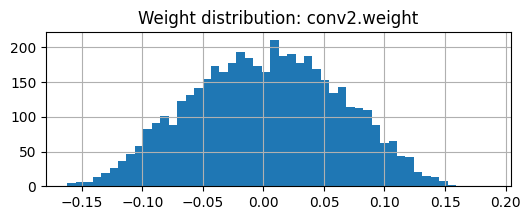

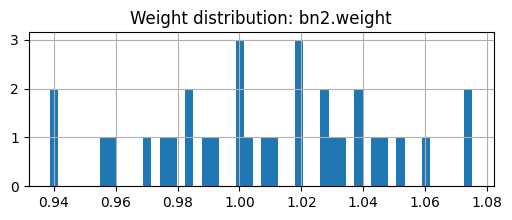

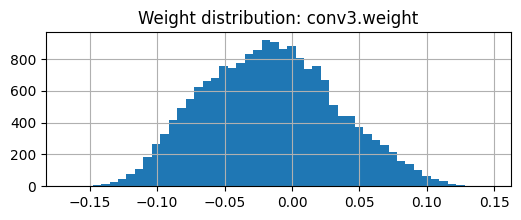

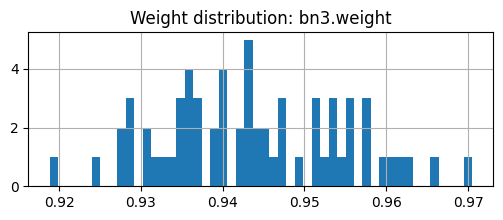

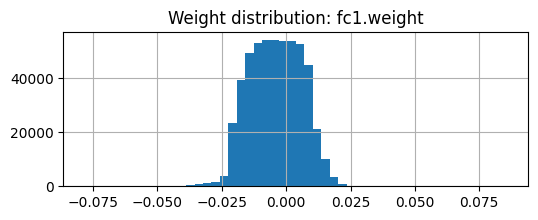

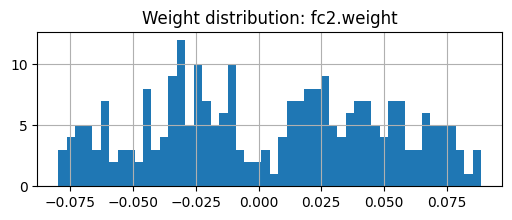

In [23]:
#Vẽ histogram của weight từng layer
for name, param in model.named_parameters():
    if 'weight' in name:
        plt.figure(figsize=(6, 2))
        plt.hist(param.data.cpu().numpy().flatten(), bins=50)
        plt.title(f"Weight distribution: {name}")
        plt.grid(True)
        plt.show()


In [24]:
#In trọng số & độ lệch từng layer
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"\nLayer: {name}")
        print(f"Shape: {param.shape}")
        print(f"Mean: {param.data.mean():.6f}, Std: {param.data.std():.6f}")



Layer: conv1.weight
Shape: torch.Size([16, 3, 3, 3])
Mean: -0.018584, Std: 0.118944

Layer: conv1.bias
Shape: torch.Size([16])
Mean: -0.089849, Std: 0.087386

Layer: bn1.weight
Shape: torch.Size([16])
Mean: 0.994366, Std: 0.046211

Layer: bn1.bias
Shape: torch.Size([16])
Mean: 0.012614, Std: 0.047845

Layer: conv2.weight
Shape: torch.Size([32, 16, 3, 3])
Mean: 0.001969, Std: 0.060760

Layer: conv2.bias
Shape: torch.Size([32])
Mean: -0.018742, Std: 0.041023

Layer: bn2.weight
Shape: torch.Size([32])
Mean: 1.009160, Std: 0.036142

Layer: bn2.bias
Shape: torch.Size([32])
Mean: 0.008288, Std: 0.039296

Layer: conv3.weight
Shape: torch.Size([64, 32, 3, 3])
Mean: -0.016456, Std: 0.049017

Layer: conv3.bias
Shape: torch.Size([64])
Mean: 0.002647, Std: 0.033248

Layer: bn3.weight
Shape: torch.Size([64])
Mean: 0.943741, Std: 0.011105

Layer: bn3.bias
Shape: torch.Size([64])
Mean: -0.052976, Std: 0.012119

Layer: fc1.weight
Shape: torch.Size([128, 4096])
Mean: -0.004046, Std: 0.010176

Layer: f